In [10]:
import pandas as pd
import numpy as np

import re

from sklearn.preprocessing import StandardScaler
import math
import scipy.stats as st
from scipy.stats import bayes_mvs
from scipy.sparse import csr_matrix

from time import time
import copy
import pickle
import missingno as msno

In [11]:
!ls

bayes_avg_eqn.png      interactions_train.csv	    RAW_recipes.csv
food_cluster.ipynb     interactions_validation.csv  README.md
food_EDA.ipynb	       PP_recipes.csv		    view_pkl.ipynb
ingr_map.pkl	       PP_users.csv
interactions_test.csv  RAW_interactions.csv


<h4><b>What is the Bayesian average?</b></h4>
The Bayesian average uses two constants to offset the arithmetic average of an individual product. This is important as otherwise products with only one five star rating are affoarding the same quality ranking as products with thousands of five star reviews. To account for differences in certainty, the rating for recipes with less than a critical number of reviews are adjusted, whlile recipes above this threshold are only very slightly adjusted. The critical value (C) is the number of reviews of the 25% quartile, which for our dataset is 1. The formula for the Bayesian average (r bar) is shown below where r and c are the rating and rating count for an individual recipe and C and R are critical threshold and average rating.

<h3></h3>
<h3>Importing data</h3>

In [15]:
def import_data():
    #cleaned recipes
    recipes = pd.read_csv('PP_recipes.csv')
    del recipes['i']
    del recipes['name_tokens']
    del recipes['ingredient_tokens']
    del recipes['steps_tokens']
    recipes = recipes.set_index('id')

    #ratings
    ratings = pd.read_csv('RAW_interactions.csv')
    del ratings['user_id']
    del ratings['date']
    del ratings['review']
    ratings = ratings.set_index('recipe_id')

    #raw recipe info
    raw_recipes = pd.read_csv('RAW_recipes.csv')
    del raw_recipes['contributor_id']
    del raw_recipes['submitted']
    del raw_recipes['tags']
    del raw_recipes['steps']
    del raw_recipes['description']
    raw_recipes = raw_recipes.set_index('id')

    return (recipes, raw_recipes, ratings)

In [16]:
recipes, raw_recipes, ratings = import_data()

In [17]:
ratings

,rating
recipe_id,
40893,4
40893,5
44394,4
85009,5
85009,5
...,...
72730,0
386618,5
78003,5


<Axes: >

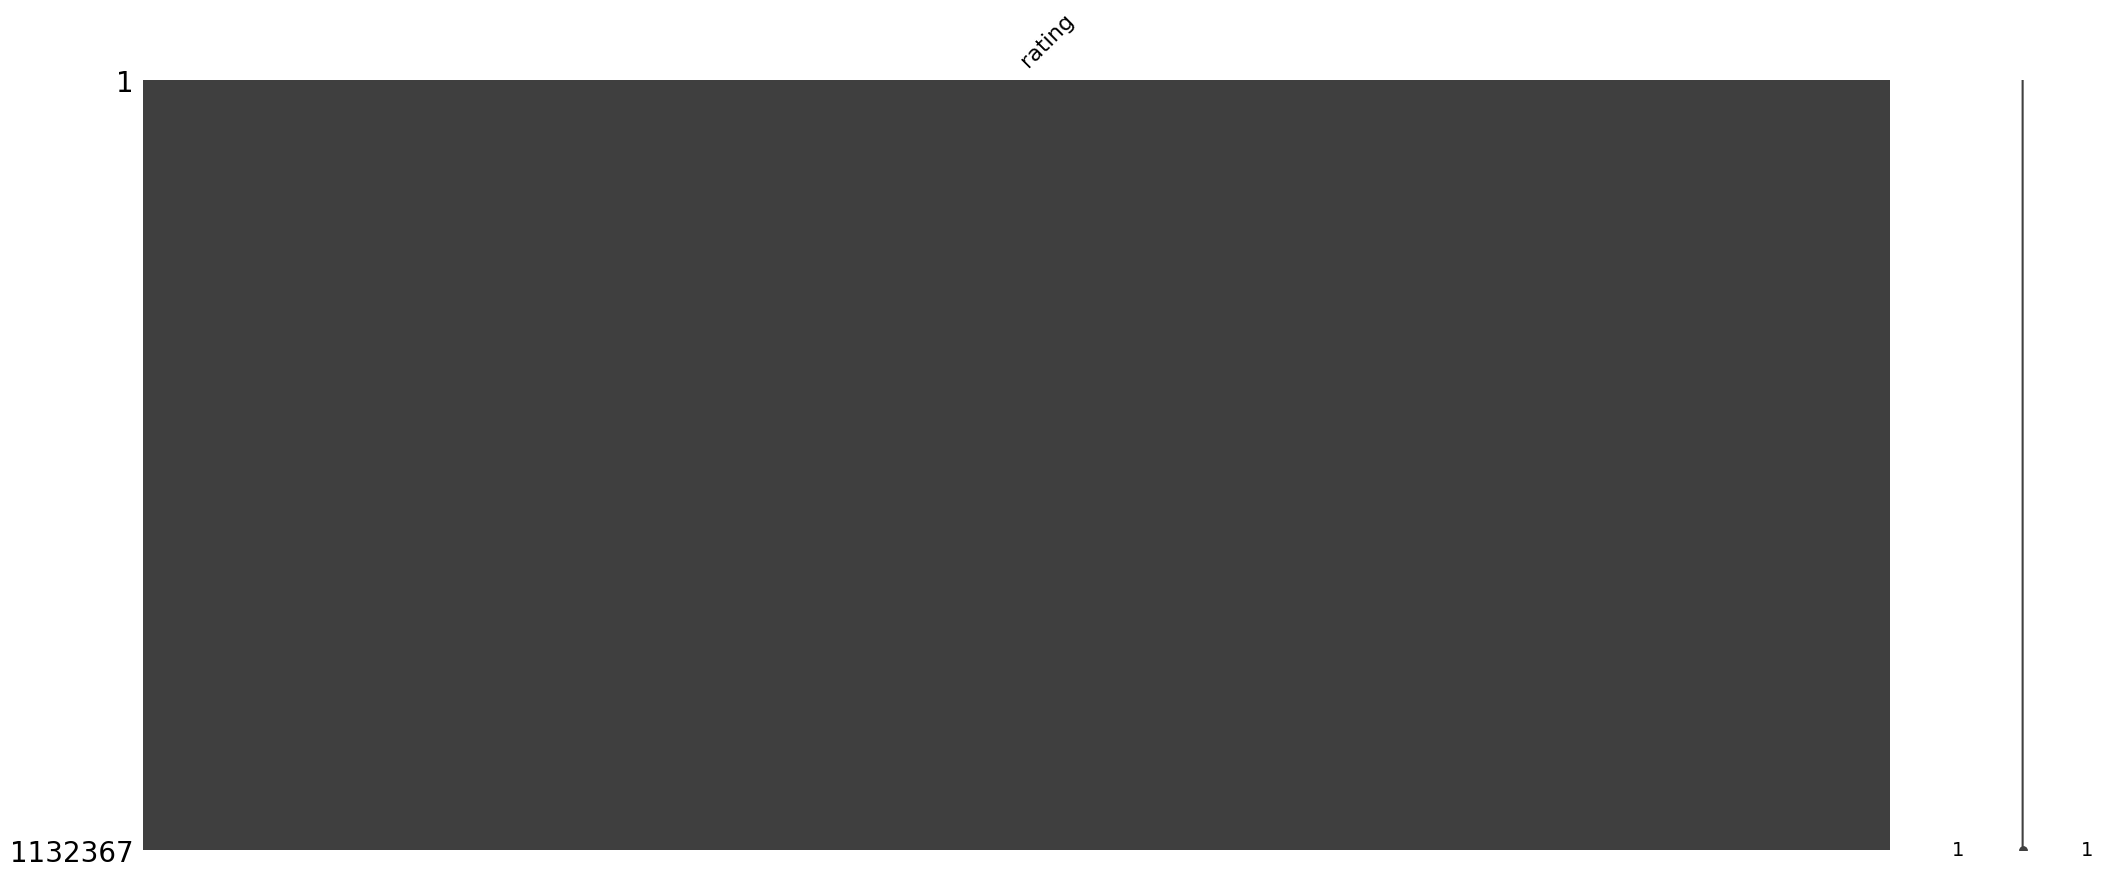

In [18]:
msno.matrix(ratings)

In [19]:
raw_recipes

,name,minutes,nutrition,n_steps,ingredients,n_ingredients
id,,,,,,
137739,arriba baked winter squash mexican style,55,"[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['winter squash', 'mexican seasoning', 'mixed ...",7
31490,a bit different breakfast pizza,30,"[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['prepared pizza crust', 'sausage patty', 'egg...",6
112140,all in the kitchen chili,130,"[269.8, 22.0, 32.0, 48.0, 39.0, 27.0, 5.0]",6,"['ground beef', 'yellow onions', 'diced tomato...",13
59389,alouette potatoes,45,"[368.1, 17.0, 10.0, 2.0, 14.0, 8.0, 20.0]",11,"['spreadable cheese with garlic and herbs', 'n...",11
44061,amish tomato ketchup for canning,190,"[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,"['tomato juice', 'apple cider vinegar', 'sugar...",8
...,...,...,...,...,...,...
486161,zydeco soup,60,"[415.2, 26.0, 34.0, 26.0, 44.0, 21.0, 15.0]",7,"['celery', 'onion', 'green sweet pepper', 'gar...",22
493372,zydeco spice mix,5,"[14.8, 0.0, 2.0, 58.0, 1.0, 0.0, 1.0]",1,"['paprika', 'salt', 'garlic powder', 'onion po...",13
308080,zydeco ya ya deviled eggs,40,"[59.2, 6.0, 2.0, 3.0, 6.0, 5.0, 0.0]",7,"['hard-cooked eggs', 'mayonnaise', 'dijon must...",8


<Axes: >

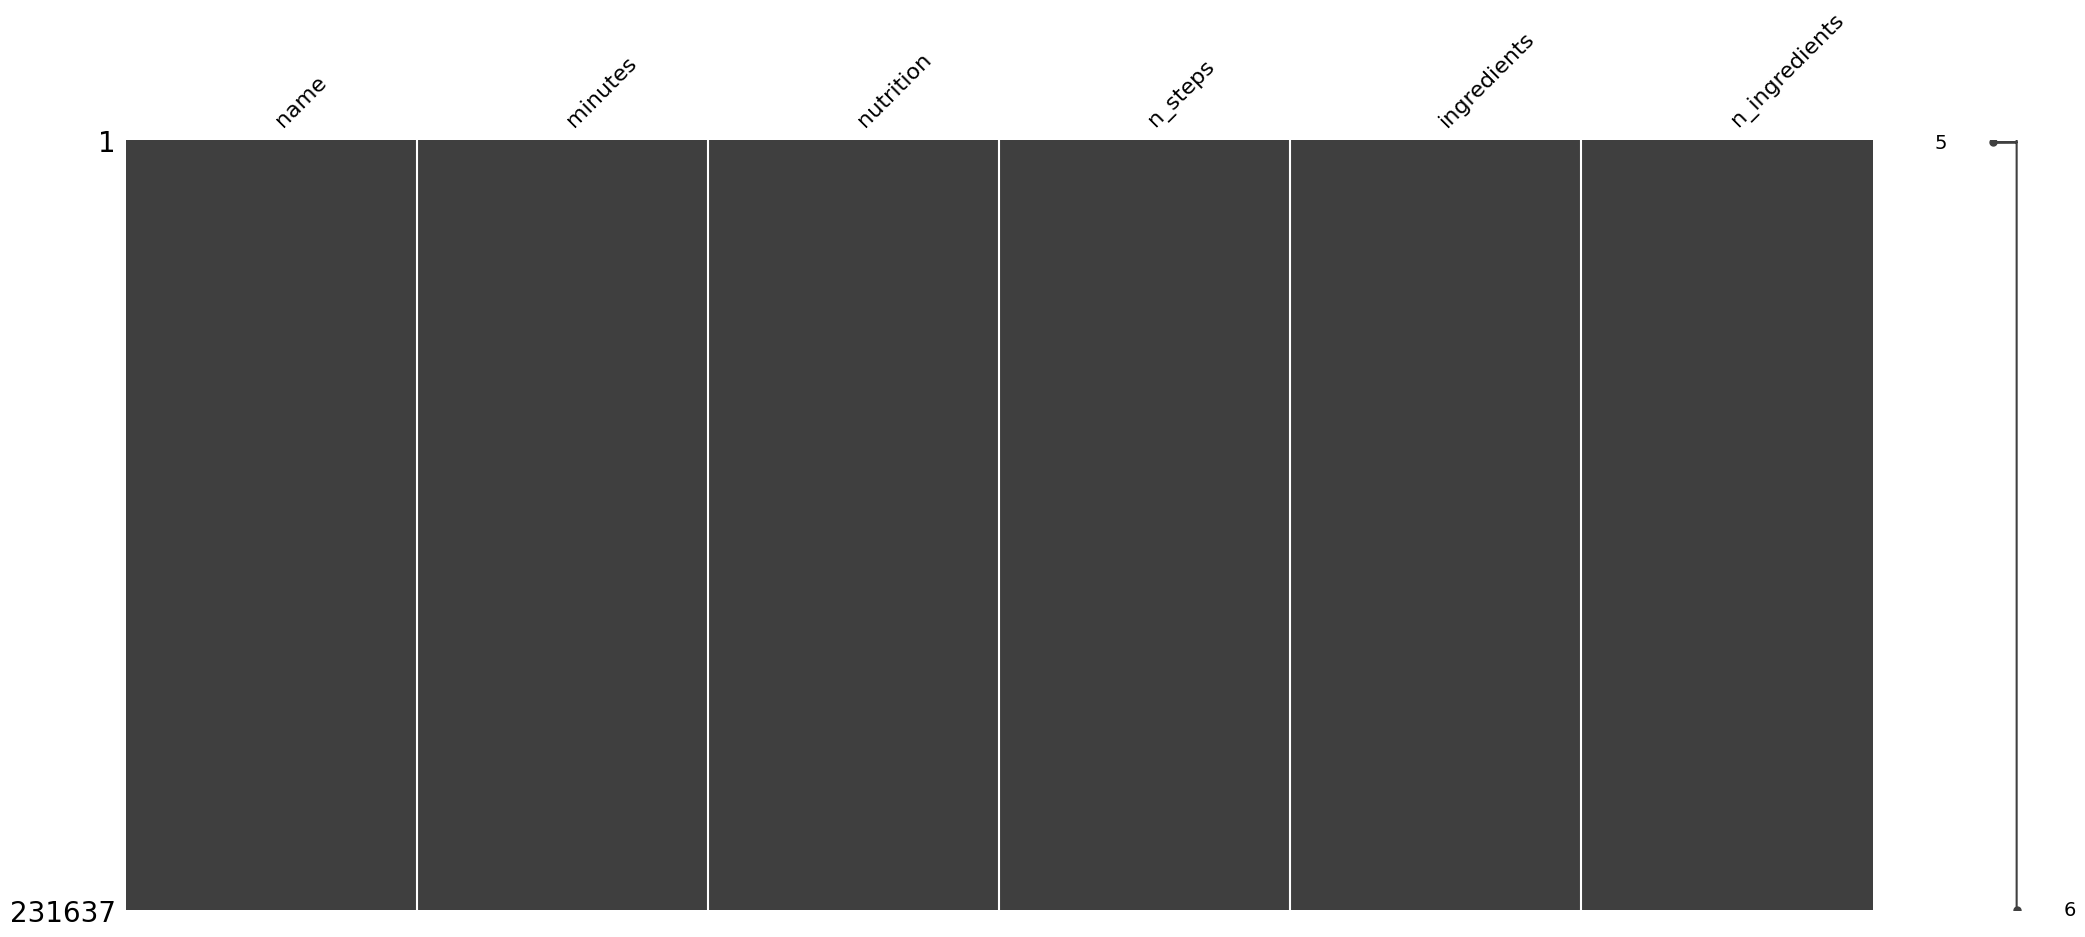

In [20]:
msno.matrix(raw_recipes);

In [21]:
recipes

,techniques,calorie_level,ingredient_ids
id,,,
424415,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[389, 7655, 6270, 1527, 3406]"
146223,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[2683, 4969, 800, 5298, 840, 2499, 6632, 7022,..."
312329,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...",1,"[1257, 7655, 6270, 590, 5024, 1119, 4883, 6696..."
74301,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[7940, 3609, 7060, 6265, 1170, 6654, 5003, 3561]"
76272,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",0,"[3484, 6324, 7594, 243]"
...,...,...,...
323143,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,"[840, 208, 2499, 2683, 1925, 335, 1511]"
149114,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,"[2499, 4717, 1168, 6270, 6324, 7040]"
34200,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...",2,"[2378, 7655, 3219, 2320, 5168, 5319, 4189, 268..."


<Axes: >

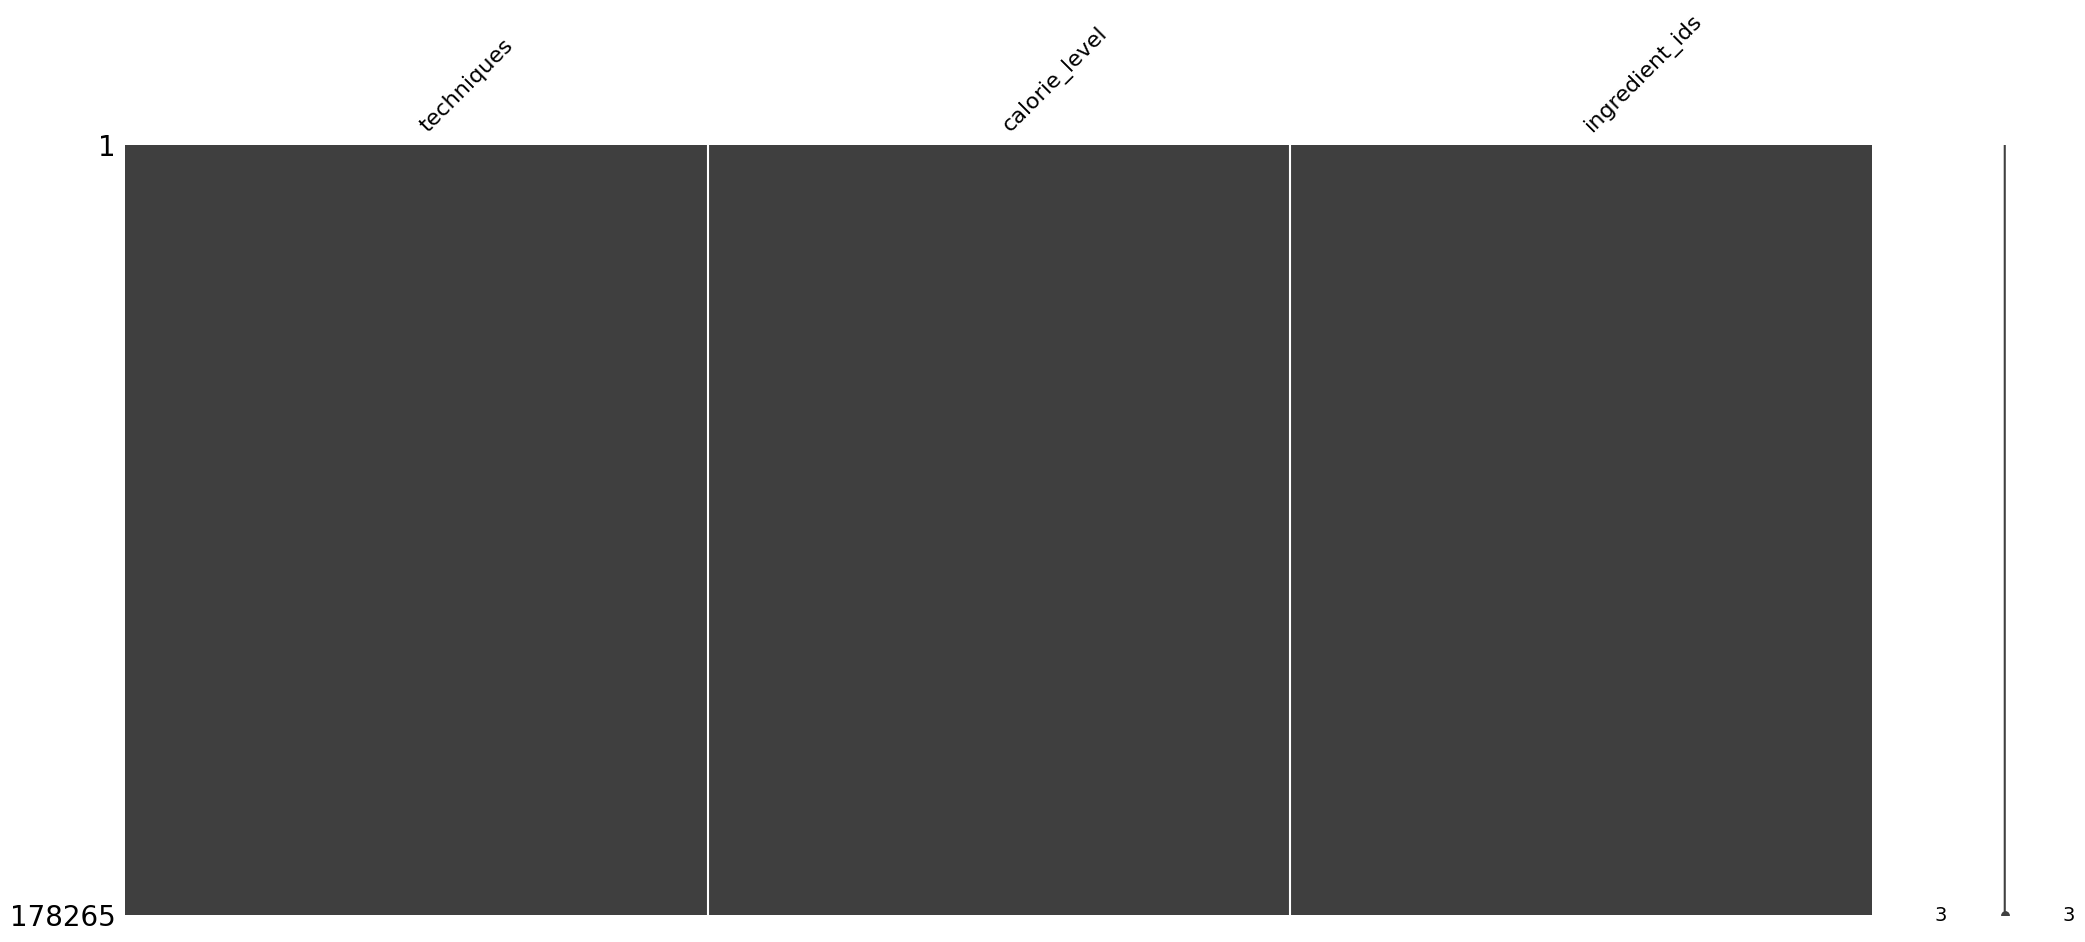

In [22]:
msno.matrix(recipes)

<h3>Ratings</h3>

In [23]:
#checking for outliers
print(f'Count of ratings > 5: {(ratings > 5).sum()[0]}')
print(f'Count of ratings < 0: {(ratings < 0).sum()[0]}')

Count of ratings > 5: 0
Count of ratings < 0: 0


In [24]:
#two methods for re-scaling reviews based on review number 

#bayesian ci
def bayes_ci(n,rating,alpha=0.95):
    mean,_,_ = bayes_mvs(n,alpha)
    return mean.statistic

#bayesian average
avg = ratings.mean()
count = ratings.count()
C = (ratings.reset_index().groupby('recipe_id').agg('size').sort_values().quantile(.25))
m = ratings.mean().rating

def bayes_avg(n):
    avg = n.mean()
    count = n.count()
    return (avg*count+C*m)/(count+C)

In [25]:
ratings_ = copy.copy(ratings)

In [26]:
q = ratings.quantile(0.95)
C = ratings.mean()

def weighted_rating(s, m=q, c=C):
    R = s.mean()
    v = s.count()
    return ((v/(v+m) * R) + (m/(m+v) * C))[0]

In [27]:
#scale ratings
def scale_ratings(ratings):
    ratings = ratings.reset_index()
    ratings = ratings.groupby('recipe_id').agg({'rating':bayes_avg})
    #ratings = ratings.reset_index()
    #df = df.drop_duplicates(subset='recipe_id')
    return ratings #df.set_index('recipe_id')

<h3>Creating reference dataset</h3>

In [28]:
df_ref = raw_recipes[['name','ingredients']]
df_ref

,name,ingredients
id,,
137739,arriba baked winter squash mexican style,"['winter squash', 'mexican seasoning', 'mixed ..."
31490,a bit different breakfast pizza,"['prepared pizza crust', 'sausage patty', 'egg..."
112140,all in the kitchen chili,"['ground beef', 'yellow onions', 'diced tomato..."
59389,alouette potatoes,"['spreadable cheese with garlic and herbs', 'n..."
44061,amish tomato ketchup for canning,"['tomato juice', 'apple cider vinegar', 'sugar..."
...,...,...
486161,zydeco soup,"['celery', 'onion', 'green sweet pepper', 'gar..."
493372,zydeco spice mix,"['paprika', 'salt', 'garlic powder', 'onion po..."
308080,zydeco ya ya deviled eggs,"['hard-cooked eggs', 'mayonnaise', 'dijon must..."


<h4>Encoding and normalizing features</h4>

In [29]:
def scale_column(df,key):
    scaler = StandardScaler()
    return pd.DataFrame(scaler.fit_transform(np.array(df[key]).reshape(-1,1)),columns=[key])

In [30]:
cols_to_normalize = ['calorie_level','minutes','n_steps','n_ingredients','rating']

def normalize_select_cols(df,cols_to_normalize):
    for col in cols_to_normalize:
        df[col] = scale_column(df,col)
    return df

<h3>Creating clustering dataset</h3>

In [31]:
#function to time fits
def timer_func(func):
    def wrap_func(*args, **kwargs):
        t1 = time()
        result = func(*args, **kwargs)
        t2 = time()
        print(f'Function {func.__name__!r} executed in {(t2-t1):.4f}s')
        return result
    return wrap_func

In [32]:
#merging data into single usable df
def merge_frames(raw_recipes, ratings):
    return recipes.merge(raw_recipes[['minutes','nutrition','n_steps','n_ingredients']],how='inner',left_index=True,right_index=True).merge(ratings,how='inner',left_index=True,right_index=True)

In [33]:
#convert string that looks lke a list of numbers to a list of 
def string_to_list(s):
    l = re.findall(r'\d+',s)
    l = [int(num) for num in l]
    return l

In [34]:
#convert one list column to encoded columns
def transform_to_sparse(df,key,size,encoded=False,sparse=True):
    df[key]=df[key].apply(string_to_list)
    t_names = [str(n)+' '+key for n in range(size)]
    data = pd.DataFrame(df[key].to_list(), columns=t_names,index=df.index.values)
    if encoded:
        return data 
    else: 
        data = pd.get_dummies(data.stack(),sparse=sparse)
        data = data.groupby(level=0).sum()
    return data

In [35]:
#convert all keys to encoded columns
def transform_all_to_sparse(df,keys,sizes,encoded=False,sparse=True):
    #encode
    for n,key in enumerate(keys):
        data = transform_to_sparse(df,key,sizes[n],encoded[n],sparse[n])
        yield data 
        #delete original columns
        try:
            df.pop(key)
        except:
            pass

In [36]:
#combine all encoded columns into one matricies with other data
def concat_df(g,df):
    df_concat = pd.concat(g,axis=1)
    df = pd.concat([df_concat,df],axis=1)

    with open('concat_df.pkl','wb') as f:
        pickle.dump(df,f)
    
    return df


<h3>Data cleaning pipeline</h3>

In [37]:
#class to do all 
@timer_func
class CleanAndTransform():
    def __init__(self,keys=['default'],sizes=(100),encoded=(False),sparse=True,cols_to_normalize=['default']):
        self.recipes, self.raw_recipes, self.ratings = import_data()   
        self.ratings = scale_ratings(self.ratings)
        self.df = merge_frames(self.raw_recipes, self.ratings)
        self.cols_to_normalize = cols_to_normalize
        self.df = normalize_select_cols(self.df,self.cols_to_normalize)
        self.df = self.df.dropna()
        self.sizes = sizes
        self.encoded = encoded
        self.keys = keys
        self.sparse = sparse

    def __call__(self,length=None):
        self.df = self.df[:length]
        self.g = transform_all_to_sparse(self.df,self.keys,self.sizes,self.encoded,self.sparse)
        df = concat_df(self.g,self.df)
        return df

<h4>Minidataset as a pandas dataframe</h4>

In [38]:
keys  = ['techniques','ingredient_ids','nutrition']
sizes = (58,20,14)
encoded = (True,False,False)
sparse = (False, False, False)

transformer = CleanAndTransform(keys,sizes,encoded,sparse,cols_to_normalize)
df_full = transformer(length=500)
df_full

Function 'CleanAndTransform' executed in 56.9948s


,0 techniques,1 techniques,2 techniques,3 techniques,4 techniques,5 techniques,6 techniques,7 techniques,8 techniques,9 techniques,...,3200,3568,4060,4101,9276,calorie_level,minutes,n_steps,n_ingredients,rating
146223,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,-1.090600,-0.002384,-1.474377,-0.936042,0.386254
74301,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,-1.090600,-0.002382,-0.490529,-1.246197,0.971555
76272,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1.436299,-0.002381,0.985243,0.924886,0.386254
163861,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.172849,-0.002372,2.706977,1.235041,-2.447665
116395,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1.436299,-0.002377,0.001395,-1.246197,-1.583612
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125859,1,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,1.436299,-0.002386,-0.244567,-0.936042,-0.285298
15832,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0.172849,-0.002360,2.461015,0.304577,1.471971
126527,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0.172849,-0.002378,-1.228415,0.614732,0.658396
8211,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,-1.090600,-0.002384,-0.490529,-0.625887,-1.066198


In [39]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 146223 to 23399
Columns: 1604 entries, 0 techniques to rating
dtypes: float64(5), int64(1599)
memory usage: 6.1 MB


In [40]:
df_full.describe()

,0 techniques,1 techniques,2 techniques,3 techniques,4 techniques,5 techniques,6 techniques,7 techniques,8 techniques,9 techniques,...,3200,3568,4060,4101,9276,calorie_level,minutes,n_steps,n_ingredients,rating
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.0,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.392000,0.010000,0.002000,0.176000,0.240000,0.0,0.002000,0.034000,0.006000,0.348000,...,0.002000,0.002000,0.002000,0.002000,0.002000,-0.052045,-0.002368,0.035338,0.036603,0.029626
std,0.488686,0.099598,0.044721,0.381202,0.427511,0.0,0.044721,0.181411,0.077304,0.476813,...,0.044721,0.044721,0.044721,0.044721,0.044721,0.971706,0.000153,1.015948,0.964019,0.999905
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-1.090600,-0.002388,-1.474377,-1.556352,-4.607797
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-1.090600,-0.002383,-0.736491,-0.625887,-0.285298
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.172849,-0.002380,-0.244567,-0.005578,0.386254
75%,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.172849,-0.002375,0.739281,0.614732,0.658396
max,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.436299,0.001016,3.444863,3.095969,1.709710


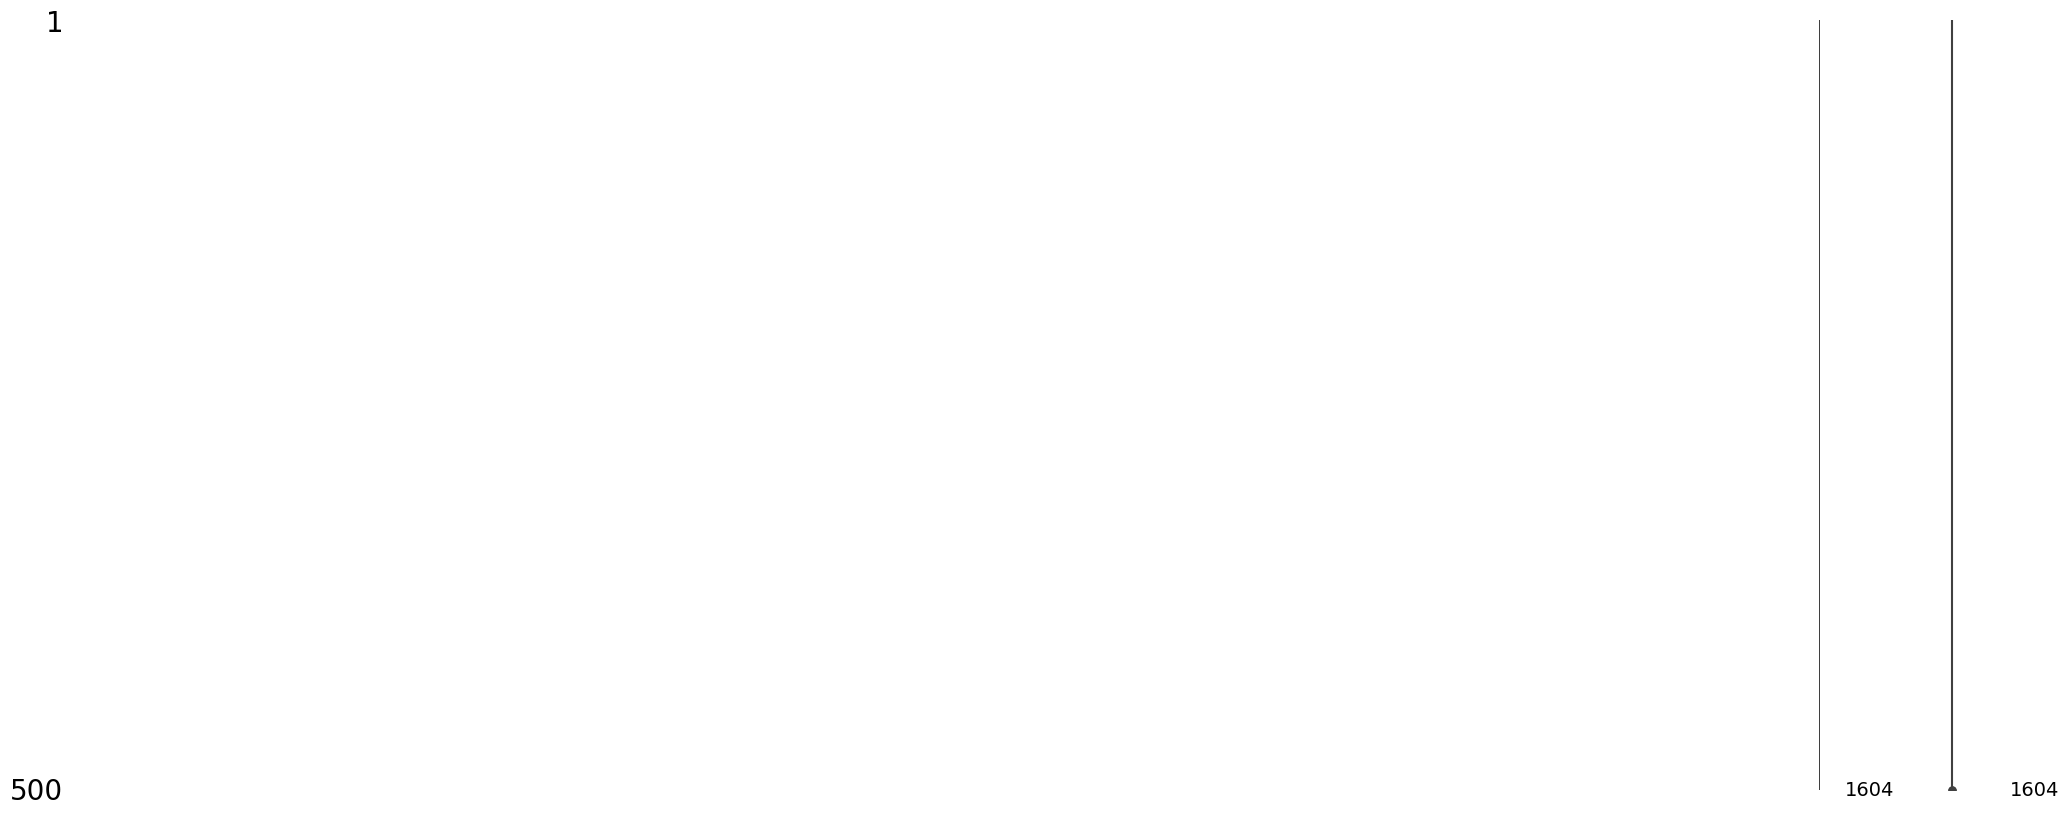

In [41]:
msno.matrix(df_full);

In [42]:
@timer_func
def to_sparse(df):
    return csr_matrix(df.values)

to_sparse(df_full)

Function 'to_sparse' executed in 0.0054s


<500x1604 sparse matrix of type '<class 'numpy.float64'>'
	with 12748 stored elements in Compressed Sparse Row format>

In [43]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 146223 to 23399
Columns: 1604 entries, 0 techniques to rating
dtypes: float64(5), int64(1599)
memory usage: 6.1 MB


<h4>Full dataset as a sparce matrix</h4>

In [44]:
keys  = ['techniques','ingredient_ids','nutrition']
sizes = (58,20,14)
encoded = (True,False,False)
sparse = (True, True, True)

transformer = CleanAndTransform(keys,sizes,encoded,sparse,cols_to_normalize)
df = transformer(length=None)
df = to_sparse(df) 
df

Function 'CleanAndTransform' executed in 53.9722s


<h2> Dimensionality Reduction </h2>

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [ ]:
df

,0 techniques,1 techniques,2 techniques,3 techniques,4 techniques,5 techniques,6 techniques,7 techniques,8 techniques,9 techniques,...,2271,2356,3177,3732,4060,calorie_level,minutes,n_steps,n_ingredients,rating
424415,0,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,0,61,6,5,4.654403
146223,1,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,0,55,10,12,4.691117
312329,0,0,0,0,1,0,0,0,0,0,...,False,False,False,False,False,1,25,6,15,4.335057
74301,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,0,15,8,8,4.753931
76272,0,0,0,0,0,0,0,0,0,1,...,False,False,False,False,False,0,20,5,4,4.649438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190651,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,2,120,8,8,4.438776
338407,0,0,0,0,1,0,0,0,0,1,...,False,False,False,False,False,0,40,14,7,4.617680
454323,0,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,0,12,13,4,4.519865
160330,1,0,0,0,0,0,0,0,0,0,...,False,False,False,False,False,0,28,8,4,4.335057


In [ ]:
pca = PCA(n_components = 0.95,random_state=10)
df.columns = df.columns.astype(str)
X_pca = pca.fit_transform(df)
print('PCA reduced dimensions from ', df.shape[1],' to ',X_pca.shape[1] ,' and preserved 95% of variance.')

c:\Users\corne\OneDrive\Documents\DS_Portfolio\food_interactions\.venv\lib\site-packages\sklearn\utils\validation.py:787: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


ValueError: Input X contains NaN.
PCA does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

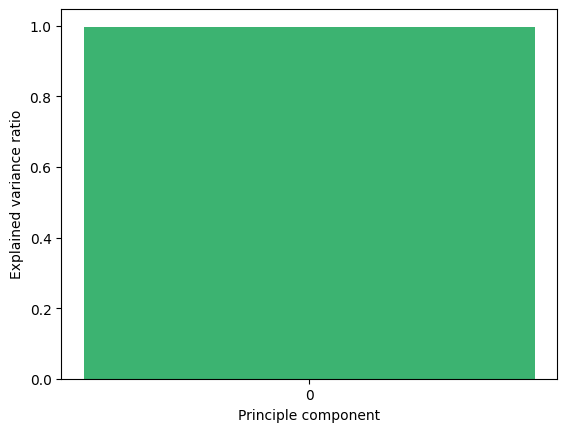

In [ ]:
plt.bar(range(pca.n_components_), pca.explained_variance_ratio_,color='mediumseagreen')
plt.xlabel('Principle component')
plt.ylabel('Explained variance ratio')
plt.xticks(range(pca.n_components_));